In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output
from collections import namedtuple, deque

from unityagents import UnityEnvironment

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
from buffer import ReplayBuffer
from model import PolicyNetwork

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
plt.style.use('ggplot')

## Set Configs

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
BATCH_SIZE = 1024
AGENT_BATCH_SIZE = 32
ENTROPY_WEIGHT = 0.01
GAMMA = 0.99
TAU = 0.99
PRINT_EVERY = 10

LR = 1e-4
EPSILON = 1e-5
WEIGHT_DECAY = 1e-4

EPS_CLIP = 0.2
GRAD_CLIP = 1
NOISE_REDUCE = 0.999

## Set Environment

In [8]:
env = UnityEnvironment(file_name='./Crawler.app', no_graphics=True)

brain_name = env.brain_names[0] # get the brain from unity environment
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


## Define [PPO](https://arxiv.org/pdf/1707.06347.pdf) Agent

In [9]:
class PPOAgent():
    """The Agent that will interacts with and learns from the environment."""
    
    def __init__(self, env, seed):
        """Initialize an Agent object."""
        
        self.brain = env.brains[env.brain_names[0]] # get the brain from unity environment
        
        self.env_info = env.reset(train_mode=True)[brain_name]
        
        self.num_agents = len(self.env_info.agents)
        
        self.state_size = self.env_info.vector_observations.shape[1]
        self.action_size = self.brain.vector_action_space_size
        
        self.batch_size = BATCH_SIZE
        self.entropy_weight = ENTROPY_WEIGHT
        self.gamma = GAMMA
        self.tau = TAU
        self.lr = LR
        self.epsilon = EPSILON
        self.weight_decay = WEIGHT_DECAY
        
        self.eps_clip = EPS_CLIP
        self.grad_clip = GRAD_CLIP
        self.noise_reduce = NOISE_REDUCE
        
        self.policy = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.lr, eps=self.epsilon, weight_decay=self.weight_decay)
        
        self.trajectory = []
        self.std_scale = 1.
        
        # set buffer
        self.buffer = ReplayBuffer(self.batch_size, self.num_agents, seed)
    
    def act(self, states):
        
        states = torch.FloatTensor(states).to(device)
                    
        self.policy.eval()
        
        with torch.no_grad():
            actions, action_log_probs, dist_entropies, state_values = self.policy(states=states, scale=self.std_scale)
        
        actions = actions.cpu().data.numpy()
        
        self.policy.train()
        
        return actions, action_log_probs, state_values, dist_entropies

    def memorize_step(self, trajectory):
        
        self.trajectory.append(trajectory)

    def memorize_trajectory(self, states):
        
        states = torch.FloatTensor(states).to(device)
        
        _, _, pending_values, _ = self.act(states)
        self.trajectory.append([states, pending_values, None, None, None, None])
        
        processed_trajectory = [None] * (len(self.trajectory) - 1)
        advantages = torch.Tensor(np.zeros((self.num_agents, 1))).to(device)
        returns = pending_values.detach()
        
        for i in reversed(range(len(self.trajectory) - 1)):
            
            states, values, actions, log_probs, rewards, dones = self.trajectory[i]
            
            states = torch.Tensor(states).to(device)
            actions = torch.Tensor(actions).to(device)
            rewards = torch.Tensor(rewards).unsqueeze(1).to(device)
            dones = torch.Tensor(dones).unsqueeze(1).to(device)
            
            next_values = self.trajectory[i + 1][1]
            returns = rewards + self.gamma * dones * returns
            TD_error = rewards + self.gamma * dones * next_values.detach() - values.detach()
            advantages = advantages * self.tau * self.gamma * dones + TD_error
            
            processed_trajectory[i] = [states, actions, log_probs, returns, advantages]
            
        self.buffer.add(processed_trajectory)
        self.trajectory = []
        
    def learn(self, next_states):

        self.memorize_trajectory(next_states)

        if len(self.buffer) * self.num_agents >= BATCH_SIZE * AGENT_BATCH_SIZE:

            for states, actions, old_log_probs, returns, advantages in self.buffer.sample():
                
                _, log_probs, state_values, dist_entropies = self.policy(states, actions)
                
                ratios = torch.exp(log_probs - old_log_probs.detach())
                
                surrogate1 = ratios * advantages
                surrogate2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
                
                policy_loss = -torch.min(surrogate1, surrogate2).mean() - self.entropy_weight * dist_entropies.mean()
                value_loss = 0.5 * (returns - state_values).pow(2).mean()
                
                total_loss = policy_loss + value_loss

                self.policy_optimizer.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.policy.parameters(), self.grad_clip)
                self.policy_optimizer.step()

            self.buffer.reset()
            
        self.std_scale = self.std_scale * self.noise_reduce
        
    def save(self, policy_path):
        
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        torch.save(self.policy.state_dict(), policy_path)
        
    def load(self, policy_path):
        
        self.policy.load_state_dict(torch.load(policy_path));
        
    def watch(self, num_episodes=10, max_time=2000):
        
        for i_episode in range(1, num_episodes+1):

            env_info = env.reset(train_mode=False)[brain_name]
            states = env_info.vector_observations

            agent_scores = np.zeros(len(env_info.agents))

            for time_step in range(max_time):

                actions, log_probs, state_values, _ = agent.act(states)
            
                env_info = env.step(actions)[brain_name]
                next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
                dones = np.array([1 if time_step else 0 for time_step in dones])

                states = next_states
                agent_scores += rewards

            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(agent_scores):.3f}, Max Score: {np.max(agent_scores):.3f}')

        env.close()

In [10]:
agent = PPOAgent(env, seed=90)

## Train The Agent

In [11]:
def train_agent(num_episodes=2000, max_time=2000):
    
    all_scores = []
    scores_target = 1250.0
    scores_window = deque(maxlen=PRINT_EVERY)
    
    # training loop
    for i_episode in range(1, num_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent_scores = np.zeros(len(env_info.agents))
        
        for time_step in range(max_time):
            
            actions, log_probs, state_values, _ = agent.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
            dones = np.array([1 if time_step else 0 for time_step in dones])
            
            agent.memorize_step([states, state_values.detach(), actions, log_probs.detach(), rewards, 1-dones])
            states = next_states
            agent_scores += rewards
            
            if all(dones):
                agent.learn(next_states)
                break
        
        scores_window.append(np.mean(agent_scores))
        all_scores.append(np.mean(agent_scores))
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(agent_scores):.3f}, Max Score: {np.max(scores_window):.3f}', end='')
        
        if i_episode % PRINT_EVERY == 0:            
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(agent_scores):.3f}, Max Score: {np.max(scores_window):.3f}')
        
        if i_episode == 1 or i_episode == 10 or i_episode == 100 or i_episode == 200 or i_episode == 500:
            agent.save(f'./agents/PPO_{brain_name}_episode{i_episode}.pth')
            
        if np.mean(scores_window) >= scores_target:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(agent_scores):.3f}, Max Score: {np.max(scores_window):.3f}')
            break
            
    agent.save(f'./agents/PPO_{brain_name}.pth')
    print('Training completed.')
     
    return all_scores

In [12]:
scores = train_agent(num_episodes=2000, max_time=2000)

Episode: 10, Average Score: 57.560, Max Score: 57.560
Episode: 20, Average Score: 61.951, Max Score: 61.951
Episode: 30, Average Score: 65.314, Max Score: 66.053
Episode: 40, Average Score: 62.255, Max Score: 67.916
Episode: 50, Average Score: 72.273, Max Score: 75.526
Episode: 60, Average Score: 80.653, Max Score: 81.783
Episode: 70, Average Score: 88.132, Max Score: 88.132
Episode: 80, Average Score: 91.542, Max Score: 96.504
Episode: 90, Average Score: 92.149, Max Score: 102.1533
Episode: 100, Average Score: 91.700, Max Score: 115.754
Episode: 110, Average Score: 123.402, Max Score: 123.402
Episode: 120, Average Score: 122.564, Max Score: 134.217
Episode: 130, Average Score: 127.071, Max Score: 145.792
Episode: 140, Average Score: 149.329, Max Score: 157.318
Episode: 150, Average Score: 160.638, Max Score: 167.446
Episode: 160, Average Score: 380.096, Max Score: 380.096
Episode: 170, Average Score: 192.383, Max Score: 426.850
Episode: 180, Average Score: 244.559, Max Score: 244.559


## Evaluate The Agent

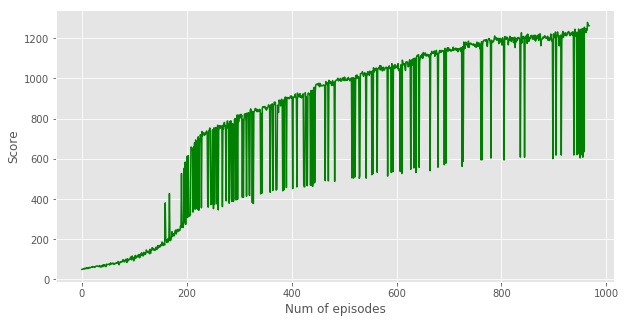

In [13]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_ppo_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [14]:
agent.load(f'./agents/PPO_{brain_name}.pth');

In [15]:
agent.watch(num_episodes=10)

Episode: 1, Average Score: 1232.323, Max Score: 1327.160
Episode: 2, Average Score: 1226.034, Max Score: 1296.926
Episode: 3, Average Score: 1272.379, Max Score: 1339.683
Episode: 4, Average Score: 1259.244, Max Score: 1313.109
Episode: 5, Average Score: 1261.936, Max Score: 1306.772
Episode: 6, Average Score: 1251.646, Max Score: 1327.671
Episode: 7, Average Score: 1265.621, Max Score: 1321.181
Episode: 8, Average Score: 1266.176, Max Score: 1298.606
Episode: 9, Average Score: 1243.781, Max Score: 1309.481
Episode: 10, Average Score: 1262.998, Max Score: 1308.947


---